In [1]:
import glob
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

In [2]:
def amplitude_spectrum(t, y, fmin=None, fmax=None, freq=None, oversample_factor=10.0):
    """ 
    Calculates the amplitude spectrum of a given signal
    
    Parameters
    ----------
        t : `array`
            Time values 
        y : `array`
            Flux or magnitude measurements
        fmin : float (default None)
            Minimum frequency to calculate spectrum. Defaults to df
        fmax : float
            Maximum frequency to calculate spectrum. Defaults to Nyquist.
        oversample_factor : float
            Amount by which to oversample the spectrum. Defaults to 10.
    """
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)

    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = 0.5 / np.median(np.diff(t))  # *nyq_mult
    if freq is None:
        freq = np.arange(fmin, fmax, df / oversample_factor)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4.0 / len(t))
    amp = np.sqrt(sc) * fct

    return freq, amp

In [3]:
# %run setup.py

In [3]:
plt.style.use('science')

In [4]:
prew = glob.glob('../prewhitening/results/spline and BIC/frequencies/*.txt')
kics = [int(pre.split('/')[-1].split('.txt')[0]) for pre in prew]
df = pd.DataFrame({'kic': kics, 'file': prew})
# af_stars = pd.read_csv('../data/catalogues/rev_AF_stars.csv', 
# #                        dtype={'kic': str}
#                       )

bg = pd.read_csv('../data/catalogues/berger_2020.tsv', delimiter='\t')
df = pd.merge(df, bg, left_on='kic', right_on='KIC')
# df = af_stars.merge(files, left_on='KIC', right_on='kic')

In [41]:
# plt.figure(figsize=[10,7])
all_f = []
all_a = []
all_p = []

fmax, amax = [], []

for index, row in tqdm.tqdm(df[:].iterrows(), total=len(df)):
    f, a, p = np.loadtxt(row['file'], usecols=[0, 1, 2], unpack=True, ndmin=2)
    a /= np.sinc(f / (2*24))
    all_f.append(f)
    all_a.append(a)
    all_p.append(p)
    
#     fmax.append(f[0])
#     amax.append(a[0])
    try:
        m = f > 14
        aidx = np.argmax(a[m])
        fmax.append(f[m][aidx])
        amax.append(a[m][aidx])
    except:
        fmax.append(0)
        amax.append(0)
    
#     plt.plot(f, a, ',k',);
    
# plt.yscale('log')

100%|██████████| 2101/2101 [00:35<00:00, 59.71it/s]


# Period luminosity

In [42]:
df['fmax'] = fmax
df['amax'] = amax

In [43]:
plt.style.use('default')

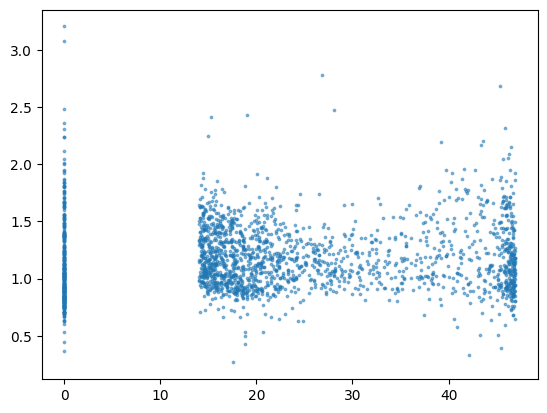

In [47]:
plt.scatter(df.fmax, df.Lum, 
#             c=np.log10(df.fmax), 
            cmap='plasma', s=3, alpha=0.5)
# plt.xlim(10000, 6500)
# plt.ylim(0.5, 2.5)

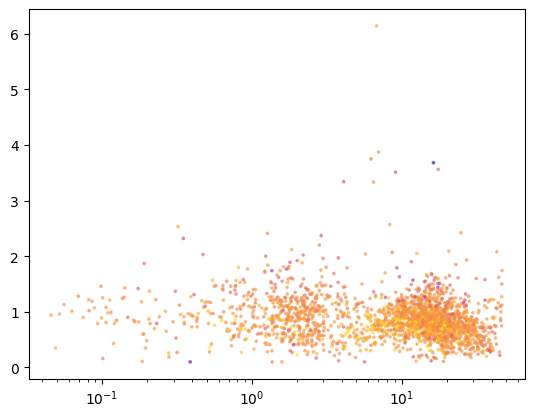

In [36]:
plt.scatter(df.fmax, df.Age, c=(df["[Fe/H]"]), cmap='plasma', s=3, alpha=0.5)
# plt.xlim(10000, 6500)
# plt.ylim(0.5, 2.5)
plt.xscale('log')

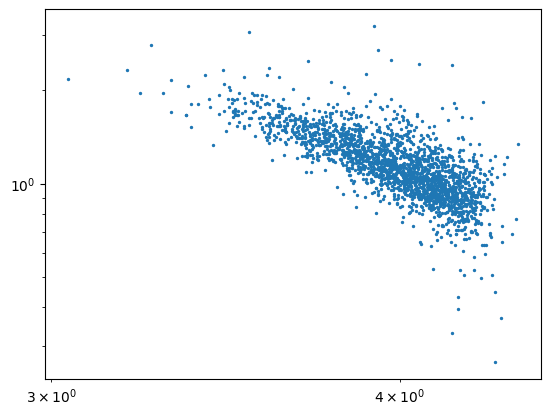

In [25]:
plt.scatter(df.logg, df.Lum, s=2)
plt.xscale('log')
plt.yscale('log')

In [7]:
df['fmax'] = fmax
df['amax'] = amax

df = df.merge(af_stars, left_on='kic', right_on='kic')

In [13]:
sort = np.argsort(df['fmax'].values)
sort = df.kic.values[sort]

<AxesSubplot:>

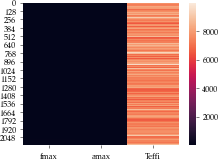

In [32]:
import seaborn as sns

sns.heatmap(df[['fmax', 'amax', 'Teffi']])

In [9]:
import tqdm

In [10]:
time, flux, err = np.loadtxt(glob.glob(f'data/lightcurves/spline corrected PDC/lc/*{sort[0]}*.csv')[0], unpack=True)
freq, amp = amplitude_spectrum(time, flux, oversample_factor=1, fmax=48.)

for kic in tqdm.tqdm(sort[:]):
    time, flux, err = np.loadtxt(glob.glob(f'data/lightcurves/spline corrected PDC/lc/*{kic}*.csv')[0], unpack=True)
    _, a = amplitude_spectrum(time, flux, freq=freq, oversample_factor=1.)
    amp = np.vstack([amp, a])

 15%|█▌        | 333/2166 [04:03<24:08,  1.27it/s]<ipython-input-2-f4339fb231af>:32: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct
100%|██████████| 2166/2166 [29:59<00:00,  1.20it/s]


In [2]:
amp = np.load('all_amps.npy')

In [3]:
from scipy.ndimage import gaussian_filter

In [15]:
filt = gaussian_filter(amp, 20)

In [16]:
filt

array([[3.21053205e-05, 3.21689941e-05, 3.22958443e-05, ...,
        7.54177017e-06, 7.54093320e-06, 7.54050708e-06],
       [3.20763315e-05, 3.21399450e-05, 3.22666757e-05, ...,
        7.54454977e-06, 7.54369381e-06, 7.54325813e-06],
       [3.20198684e-05, 3.20833647e-05, 3.22098622e-05, ...,
        7.56406908e-06, 7.56321701e-06, 7.56278325e-06],
       ...,
       [4.12425319e-05, 4.13049543e-05, 4.14294234e-05, ...,
        3.14868414e-05, 3.14910261e-05, 3.14931212e-05],
       [4.12737876e-05, 4.13362429e-05, 4.14607778e-05, ...,
        3.15291363e-05, 3.15333078e-05, 3.15353963e-05],
       [4.12893433e-05, 4.13518150e-05, 4.14763826e-05, ...,
        3.15502800e-05, 3.15544449e-05, 3.15565299e-05]])

Text(0, 0.5, 'Star label')

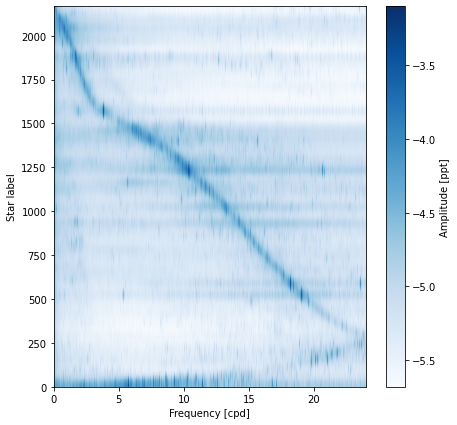

In [17]:
plt.figure(figsize=[7, 7])

plt.imshow(np.log10(filt), aspect='auto', cmap='Blues', interpolation="None", extent=[0, 48, 0, len(amp)])
plt.colorbar(label='Amplitude [ppt]')
plt.xlim(0., 24.)
plt.xlabel('Frequency [cpd]')
plt.ylabel('Star label')

# plt.savefig('cool.png', dpi=150)

In [4]:
test = []
for a in amp:
    test.append(a / np.nanmax(a))

In [5]:

test = np.array(test)

In [6]:
filt = gaussian_filter(amp, 10)

In [7]:
filt

array([[1.96699769e-05, 2.00148490e-05, 2.07010356e-05, ...,
        7.56374603e-06, 7.56389276e-06, 7.56400028e-06],
       [1.95469621e-05, 1.98896059e-05, 2.05713545e-05, ...,
        7.53143311e-06, 7.53154350e-06, 7.53163221e-06],
       [1.93045924e-05, 1.96428474e-05, 2.03158554e-05, ...,
        7.46902524e-06, 7.46906983e-06, 7.46912445e-06],
       ...,
       [1.87003177e-05, 1.89580316e-05, 1.94693121e-05, ...,
        3.24352070e-05, 3.24070856e-05, 3.23930198e-05],
       [1.84196144e-05, 1.86735654e-05, 1.91773898e-05, ...,
        3.23844408e-05, 3.23548374e-05, 3.23400270e-05],
       [1.82760490e-05, 1.85280779e-05, 1.90280939e-05, ...,
        3.23592371e-05, 3.23288828e-05, 3.23136951e-05]])

Text(0, 0.5, 'Star label')

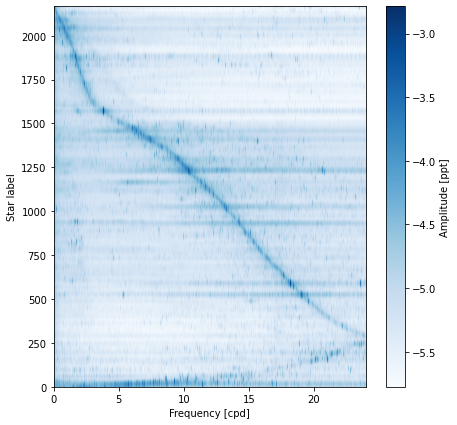

In [8]:
plt.figure(figsize=[7, 7])

plt.imshow(np.log10(filt), aspect='auto', cmap='Blues', interpolation="None", extent=[0, 48, 0, len(amp)])
plt.colorbar(label='Amplitude [ppt]')
plt.xlim(0., 24.)
plt.xlabel('Frequency [cpd]')
plt.ylabel('Star label')

# plt.savefig('cool.png', dpi=150)

Text(0, 0.5, 'Star label')

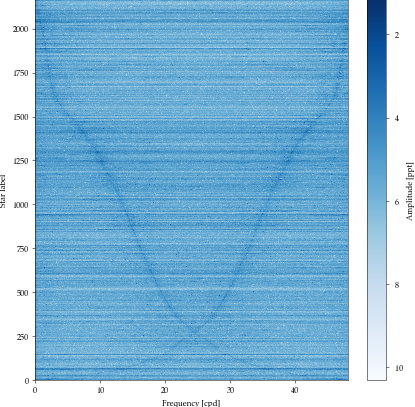

In [18]:
plt.figure(figsize=[7, 7])

plt.imshow(np.log10(amp), aspect='auto', cmap='Blues', interpolation="None", extent=[0, 48, 0, len(amp)])
plt.colorbar(label='Amplitude [ppt]')
plt.xlim(0., 48.)
plt.xlabel('Frequency [cpd]')
plt.ylabel('Star label')

# plt.savefig('cool.png', dpi=150)

In [ ]:
plt.figure(figsize=[10,10])

plt.imshow(np.log10(amp), aspect='auto')
plt.colorbar()

In [49]:
all_f = np.hstack(all_f)
all_a = np.hstack(all_a)
all_p = np.hstack(all_p)

Text(0, 0.5, 'Amplitude')

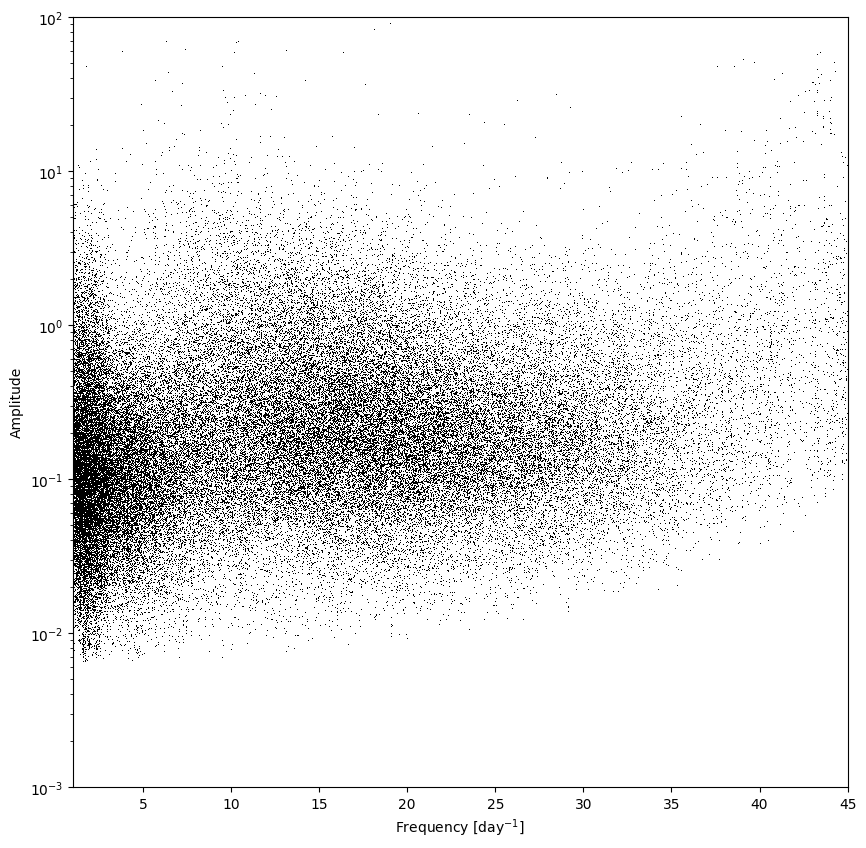

In [50]:
# plt.figure(figsize=[3.333333333333333, 3.333333333333333])
plt.figure(figsize=[10,10])
plt.plot(all_f, all_a, ',k', alpha=1, rasterized=True)
plt.xlim(1, 45)
plt.yscale('log')
# plt.xscale('log')
plt.ylim(10**-3, 10**2)
plt.xlabel('Frequency [day$^{-1}$]')
plt.ylabel('Amplitude')

# plt.savefig(overleaf_path + 'freq_amp_all.pdf', dpi=300)

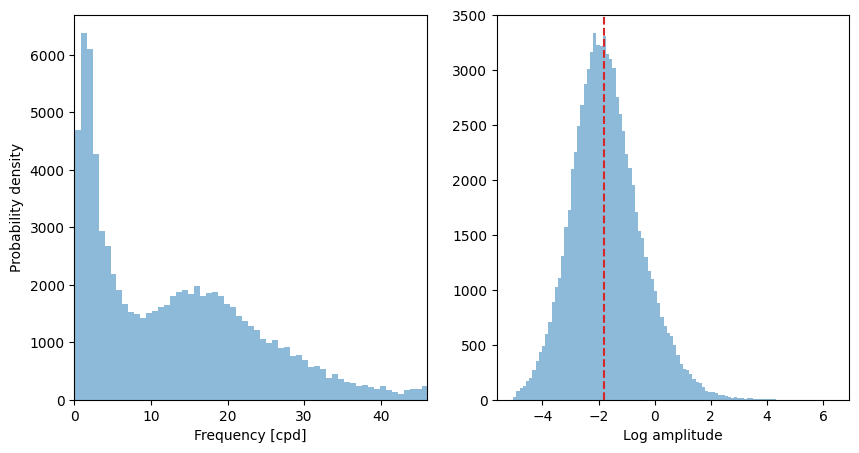

In [51]:
fig, axes = plt.subplots(1,2, figsize=[10,5])

ax = axes[0]
ax.hist(all_f, bins=60, density=False, color='C0', alpha=0.5);
ax.set(xlim=[0,46], xlabel='Frequency [cpd]', ylabel='Probability density')

ax = axes[1]
ax.hist(np.log(all_a), bins=100, alpha=0.5);
ax.set(xlabel='Log amplitude')
ax.axvline(np.median(np.log(all_a)), c='C3', linestyle='dashed')

In [11]:
1/0.5

2.0

In [12]:
np.log10(20)

1.3010299956639813

In [76]:
plt.rcParams['axes.unicode_minus'] = False

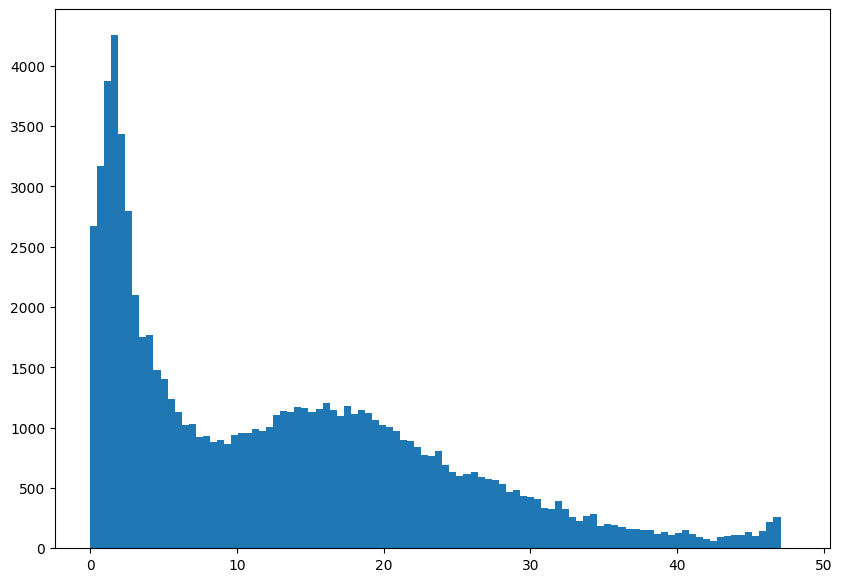

In [52]:
plt.figure(figsize=[10,7])
plt.hist(all_f, bins=100, range=(1e-3, 48));

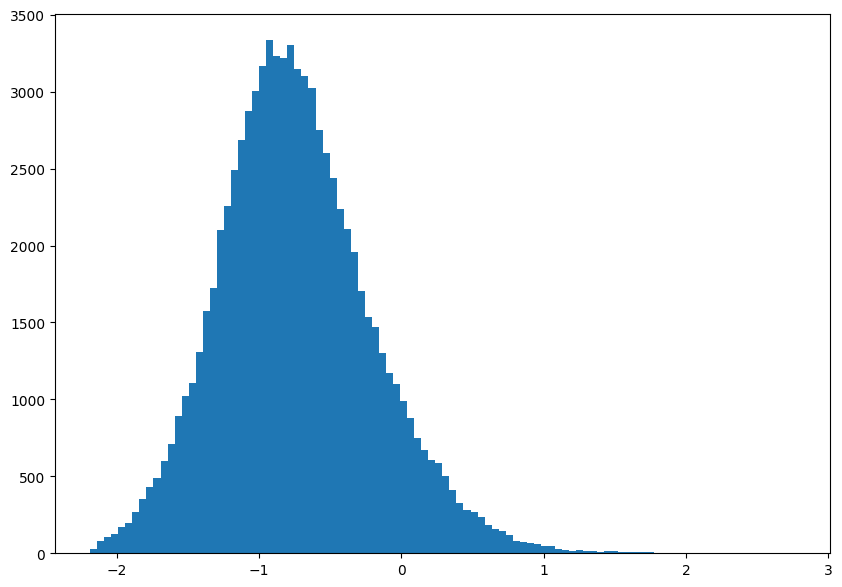

In [53]:
plt.figure(figsize=[10,7])
plt.hist(np.log10(all_a), bins=100);

In [64]:
plt.style.use('science')
plt.rcParams['axes.unicode_minus'] = False

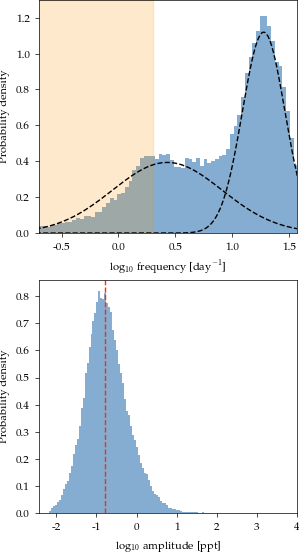

In [65]:
from sklearn.mixture import GaussianMixture

fig, axes = plt.subplots(2,1, figsize=[3.333, 6.666])
X = (np.log10(all_f)).reshape(-1, 1)

# fit models with 3 components
N = np.arange(1,3)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# # compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]


# plot 1: data + best-fit mixture
ax = axes[0]
M_best = models[np.argmin(AIC)]

x = np.linspace(X.min(), X.max(), 1000)
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 100, density=True, histtype='stepfilled', alpha=0.5)
# ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--', c='black')
ax.set_xlabel(r'log$_{10}$ frequency [day$^{-1}$]')
ax.set_ylabel('Probability density')

# ax.text(0,1,f'p-modes')
# ax.text(0,1,f'p-modes')

ax.set_xlim(-0.7, X.max()-0.1)
ax.set_ylim(0, 1.3)


ax.axvspan(*np.log10([1/300, 1/0.5]), alpha=0.2, color='C2')

ax = axes[1]

ax.hist(np.log10(all_a), density=True, bins=100, histtype='stepfilled', alpha=0.5);
ax.set(xlabel=r'log$_{10}$ amplitude [ppt]', ylabel='Probability density')
ax.axvline(np.median(np.log10(all_a)), c='C3', linestyle='dashed')
ax.set_xlim(None, 4)

plt.savefig('freq_amp_dist.pdf', dpi=300, bbox_inches='tight', pad_inches=0.)

In [63]:
10**0.5

3.1622776601683795

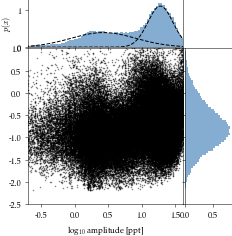

In [276]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=[3.333, 3.33])

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

ax1 = ax

# use the previously defined function
ax = ax_histx
M_best = models[np.argmin(AIC)]

x = np.linspace(X.min(), X.max(), 1000)
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 100, density=True, histtype='stepfilled', alpha=0.5)
# ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--', c='black')
ax1.set_xlabel(r'log$_{10}$ frequency [day$^{-1}$]')
ax.set_ylabel('$p(x)$')
ax.set_xlim(-0.7, X.max()-0.05)
ax.set_ylim(0, 1.3)
ax.tick_params(axis="x", labelbottom=False)

# ax.axvspan(*np.log10([1/300, 1/0.5]), alpha=0.2, color='C2')


ax = ax_histy
ax.hist(np.log10(all_a), density=True, bins=100, histtype='stepfilled', alpha=0.5, orientation='horizontal');
ax1.set(xlabel=r'log$_{10}$ amplitude [ppt]')
# ax.axvline(np.median(np.log(all_a)), c='C3', linestyle='dashed')
# ax.set_xlim(None, 4)
# ax.set_yticks([])
ax.set_ylim(-2.5,1)
ax.tick_params(axis="y", labelleft=False)
# ax.axhspan(*[-1., 1.], alpha=0.2, color='C2')

ax1.plot(X, np.log10(all_a), '.k', alpha=0.5, markersize=1, rasterized=True)

plt.savefig('freq_dist.pdf', dpi=300, bbox_inches='tight', pad_inches=0)


In [235]:
import batman
import astropy.units as u
def generate_transit_model(time, period, rp, stellar_rad=1.7):
    params = batman.TransitParams()
    params.t0 = time[0]                 #time of inferior conjunction
    params.per = period                      #orbital period
    params.rp = rp                   #planet radius (in units of stellar radii)
    params.a = 30.                       #semi-major axis (in units of stellar radii)
    params.inc = 90#np.degrees(np.arccos(0.5 * 1.7 / params.a))                     #orbital inclination (in degrees)
    params.ecc = 0.                    #eccentricity
    params.w = 90.                       #longitude of periastron (in degrees)
    params.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"   

    m = batman.TransitModel(params, time)    #initializes model
    batman_flux = m.light_curve(params) - 1
    return batman_flux

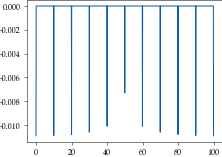

In [241]:
time = np.linspace(0,100,1000)
model = generate_transit_model(time, 10, 0.1)
plt.plot(time, model)

In [242]:
np.log10(np.abs(np.min(model)*1e3))

1.0376787018553113

In [240]:

(2 * u.R_earth).to(u.R_sun), (1 * u.R_jup).to(u.R_sun)

(<Quantity 0.01833578 solRad>, <Quantity 0.10276269 solRad>)

In [232]:

# plot 3: posterior probabilities for each component
# ax = axes[1]

# p = responsibilities
# # p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
# p = p.cumsum(1).T

# ax.fill_between(x, 0, p[0], color='gray', alpha=0.3)
# ax.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
# ax.fill_between(x, p[1], 1, color='gray', alpha=0.7)
# # ax.set_ylim(0, 1)
# ax.set_xlabel('Orthogonal distance')
# ax.set_ylabel(r'$p({\rm class}|x)$')


# # ax.axvline(0., c='red')
# # ax.axvline(-0.3, c='red')
# # # ax.axvline(0., c='red')
# # ax.text(0., 0.5, 'Fundamental', rotation='vertical',verticalalignment='center')
# # ax.text(-0.3, 0.5, 'First overtone', rotation='vertical',verticalalignment='center')
# # ax.text(-0.6, 0.5, 'Second overtone', rotation='vertical',verticalalignment='center')

# plt.savefig('simple_gmm.png', dpi=300, bbox_inches='tight')

In [233]:
np.median(pdf_individual, axis=0)

array([1.91842457e-10, 9.16498461e-02])

<ipython-input-12-4099e0ef5dd1>:8: RuntimeWarning: invalid value encountered in log
  ax.hist(np.log(all_a), bins=100);
/home/daniel/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/daniel/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


[Text(0.5, 0, 'Log amplitude')]

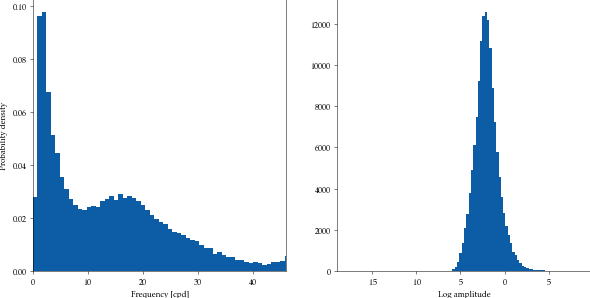

In [12]:
fig, axes = plt.subplots(1,2, figsize=[10,5])

ax = axes[0]
ax.hist(all_f, bins=60, density=True);
ax.set(xlim=[0,46], xlabel='Frequency [cpd]', ylabel='Probability density')

ax = axes[1]
ax.hist(np.log(all_a), bins=100);
ax.set(xlabel='Log amplitude')